In [1]:
# milostipanov@gmail.com 
# https://github.com/meteorids
# 2022

#This Code is to process the output from the NeuralNetwork-Predict. Creating plots and statistics. Will combine the output file from the NN and the NILU-data-process for time stamps.

In [5]:
#This block reads the daily data from NN-output and NILU-data-process output.

import pandas as pd
import numpy as np
import math
# Seting up data:

processed_data = pd.read_csv('../MachineLearning-NILU/nnoutput-2014.txt',  sep=r'\s+', header=None)
timestamp     = pd.read_csv('./NILU-OUT/processed_nilu-2014.txt',  sep=r'\s+', header=None)

#year = str(timestamp[1])
date_nilu = timestamp[3]
time_nilu = timestamp[5]
doy_nilu  = timestamp[4]
sza_nilu  = timestamp[0]
scaled_ozone_nilu   = processed_data[0]
vol_frac_nilu       = processed_data[1]*10**-7


# Converting scaled ozone to Dobson Units
# Scaled to standard US atmosphere, the equivalent depth of ozone is 3.45×10^−3 m, in Dobson units= 345 DU. 1 eqd = 10^5 DU
ozone_DU_nilu = scaled_ozone_nilu*345
# Converting cloud particle vol. frac. to COD. Based on simulations. see code: COD_vs_volfrac.ipynb
cod_nilu = vol_frac_nilu*152596238.214


df_nilu = pd.DataFrame({'DATE_NILU': date_nilu,
                   'TIMEUTC_NILU': time_nilu,
                    'DOY_NILU': doy_nilu,
                   'SZA_NILU': sza_nilu,
                   'O3_NILU': ozone_DU_nilu,
                   'COD_NILU': cod_nilu})

df_nilu.to_csv("./STATS-PLOTS-OUT/dataframe.csv")
mylambda1 = lambda x: math.cos(math.radians(x))
df_nilu['SZA_COS_NILU'] = df_nilu['SZA_NILU'].apply(mylambda1)
df_nilu['COD_NILU_CORR'] = df_nilu['COD_NILU']/df_nilu['SZA_COS_NILU']

high_noons = df_nilu.loc[df_nilu.groupby('DOY_NILU').SZA_NILU.idxmin()].reset_index()

# creating a lambda function, to filter out the outliners
mylambda2 = lambda x: x if x > 200 else np.nan
high_noons['O3_NILU'] = high_noons['O3_NILU'].apply(mylambda2)
#print(high_noons)
#daily means:
ozone_daily_mean_nilu = df_nilu.groupby('DOY_NILU').O3_NILU.mean().reset_index()
doy_nilu = df_nilu.groupby('DOY_NILU').mean().reset_index()
cod_daily_mean_nilu = df_nilu.groupby('DOY_NILU').COD_NILU_CORR.mean().reset_index()

print(df_nilu)
print(ozone_daily_mean_nilu)
print(cod_daily_mean_nilu)
#print(ozone_daily_mean_nilu)


        DATE_NILU  TIMEUTC_NILU  DOY_NILU  SZA_NILU     O3_NILU  COD_NILU  \
0        20140323          1246        82    69.914  282.210127  7.132291   
1        20140323          1247        82    69.733  283.288601  7.177997   
2        20140323          1248        82    69.552  284.669306  6.998200   
3        20140323          1249        82    69.371  286.801380  7.028602   
4        20140323          1250        82    69.191  287.577334  7.286137   
...           ...           ...       ...       ...         ...       ...   
175972   20141024          1956       297    69.346  259.326761  0.182682   
175973   20141024          1957       297    69.495  256.046216  0.105954   
175974   20141024          1958       297    69.645  258.412779  0.196764   
175975   20141024          1959       297    69.795  257.382592  0.183985   
175976   20141024          2000       297    69.945  251.880893  0.077752   

        SZA_COS_NILU  COD_NILU_CORR  
0           0.343430      20.767804  

In [12]:
#Reads OMI data

df_omi = pd.read_csv('./OMI-dataprocess-output/omi_L3_daily_means.csv',  sep=r',', header=0)
year_omi = df_omi['YEAR']
month_omi = df_omi['MONTH']
day_omi = df_omi['DAY']
doy_omi = df_omi['DOY']
ozone_daily_mean_omi = df_omi['OMI_O3']

print(len(df_nilu['DOY_NILU']))
print(len(ozone_daily_mean_nilu['O3_NILU']))


print(df_nilu['DOY_NILU'])
print(ozone_daily_mean_nilu['O3_NILU'])



KeyError: 'OMI_O3'

In [13]:
#Plotting daily average ozone concentration (NILU,OMI)
#%matplotlib inline
import matplotlib.pyplot as plt
plt.subplots(tight_layout=True)
plt.scatter(df_omi['DOY'], df_omi['OMI_O3'], marker='.', color='grey')
plt.scatter(ozone_daily_mean_nilu['DOY_NILU'], ozone_daily_mean_nilu['O3_NILU'], marker='+', color='black')
plt.xlabel('Day of the year')
plt.ylabel('Total Ozone Column  [DU]')
plt.legend(['OMI','NILU'])

plt.savefig('OMI_L3_NILU_O3_2014.pdf',dpi = 300)
plt.show()
        

KeyError: 'OMI_O3'

Yearly mean relative difference:  0.026144371442449667
Yearly O3 standard deviation for NILU data:  42.57940342048814


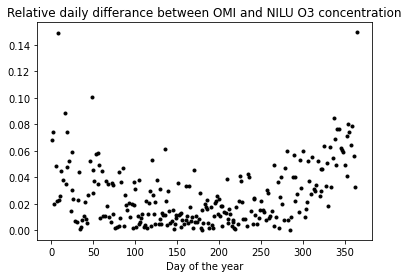

In [5]:
#Plotting relative differance between NILU and OMI data
import math

relative_differance = (abs(df_omi['OMI_O3'] - ozone_daily_mean_nilu['O3_NILU'])) / (df_omi['OMI_O3'] + ozone_daily_mean_nilu['O3_NILU'])
yearly_mean_relative_difference = relative_differance.mean()
std_nilu = high_noons['O3_NILU'].std()
print("Yearly mean relative difference: " ,yearly_mean_relative_difference)
print("Yearly O3 standard deviation for NILU data: ",std_nilu)

plt.scatter(df_omi['DOY'], relative_differance, marker='.', color='black')
plt.xlabel('Day of the year')
plt.title('Relative daily differance between OMI and NILU O3 concentration')
plt.savefig('OMI_NILU_O3_rel_diff_2014.pdf')
plt.show()

Yearly mean absolute difference:  16.015531553604326
Yearly O3 standard deviation for NILU data:  42.57940342048814
Yearly O3 standard deviation for OMI data:  37.398551644067226


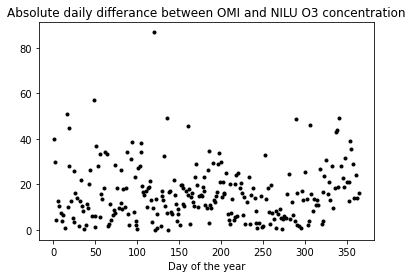

In [6]:
#Plotting absolute differance between NILU and OMI data, calculating STD for NILU and OMI yearly data

absolute_differance = (abs(df_omi['OMI_O3']-high_noons['O3_NILU']))
yearly_mean_absolute_difference = absolute_differance.mean()
std_nilu = high_noons['O3_NILU'].std()
std_omi = df_omi['OMI_O3'].std()
print("Yearly mean absolute difference: " ,yearly_mean_absolute_difference)
print("Yearly O3 standard deviation for NILU data: ",std_nilu)
print("Yearly O3 standard deviation for OMI data: ",std_omi)

plt.scatter(df_omi['DOY'], absolute_differance, marker='.', color='black')
plt.xlabel('Day of the year')
plt.title('Absolute daily differance between OMI and NILU O3 concentration')
plt.savefig('OMI_NILU_O3_abs_diff_2014.pdf')
plt.show()

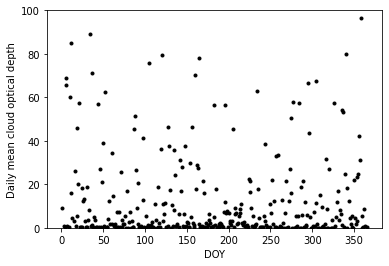

In [7]:
#Plotting cloud optical depth (predicted from NN) vs DOY
#print(cod_daily_mean_nilu)
#print(relative_differance)
plt.ylabel('Daily mean cloud optical depth')
plt.xlabel('DOY')
plt.ylim([0, 100])
#plt.xlim([0, 50])
plt.scatter(cod_daily_mean_nilu['DOY_NILU'], cod_daily_mean_nilu['COD_NILU_CORR'], marker='.', color='black')
plt.savefig('COD_vs_DOY_2014.pdf')

365
365


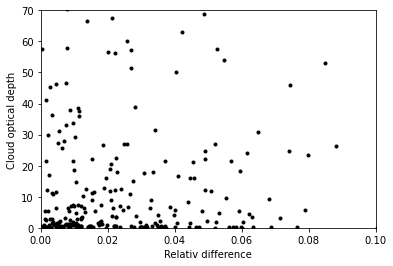

In [12]:
#plotting relativ difference vs COD
print(len(relative_differance))
print(len(cod_daily_mean_nilu['COD_NILU_CORR']))
plt.ylabel('Cloud optical depth')
plt.xlabel('Relativ difference')
plt.scatter(relative_differance, cod_daily_mean_nilu['COD_NILU_CORR'], marker='.', color='black')
plt.ylim([0, 70])
plt.xlim([0, 0.1])
plt.savefig('Rel_diff_vs_COD_2014.pdf')

In [9]:
import matplotlib.pyplot as plt
import numpy as np

import datetime
import matplotlib.dates as mdates
import pytz
from dateutil import tz

# Let's plot 1 day
# Enter a day number:
choosen_day = 153

x=[ ]
y=[ ]

for i in range(len(df.DOY)):
    if df.DOY[i] == choosen_day:
        date2 = str(df.DATE[i])
        year = date2[0:4]
        month = date2[4:6]
        day = date2[6:8]
        time2 = str(df.TIMEUTC[i])
        hour = time2[0:2]
        minute = time2[2:]
        my_datetime = datetime.datetime(int(year),int(month),int(day),int(hour),int(minute),0,0, tzinfo = pytz.utc)
        my_datetime_utc = my_datetime.strftime('%Y-%m-%d %H:%M:%S %Z%z')
#        my_datetime_est = my_datetime.astimezone(pytz.timezone('US/Eastern')).strftime('%Y-%m-%d %H:%M:%S %Z%z')
        my_datetime_est = my_datetime.astimezone(pytz.timezone('US/Eastern'))
#        print(my_datetime_est)
        x.append(my_datetime_est)
        y.append(df.O3[i])
       
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M',tz=tz.gettz('US/Eastern')))
fig.autofmt_xdate()

#ax.plot(y, marker='.')
#ax.set_xticks([i for i in range(len(y))])
#ax.set_xticklabels(x)
#ax.locator_params(nbins=10)


plt.scatter(x, y, marker='.', color='black')
plt.show()

#print(y)

NameError: name 'df' is not defined

In [ ]:
# Convert day number to date in particular year
from datetime import datetime
  
# initializing day number
day_num = "153"
  
# print day number
print("The day number : " + str(day_num))
  
# adjusting day num
#day_num.rjust(3 + len(day_num), '0')
  
# Initialize year
year = "2014"
  
# converting to date
res = datetime.strptime(year + "-" + day_num, "%Y-%j").strftime("%m-%d-%Y")
  
# printing result
print("Resolved date : " + str(res))

In [ ]:
# Check how clear the day is by plotting raw ch5 vs time

day = 153

# Clean days found so far:
# 2014: 110, 153

ch5  = timestamp[1]
ch5df = pd.DataFrame({'CH5': ch5})


CH5=[ ]
for i in range(len(df.DOY)):
    if df.DOY[i] == day:
        CH5.append(ch5df.CH5[i])
        
        
T = range(len(CH5))      


    
plt.tight_layout()
plt.plot(T, CH5, color='gray')
plt.show()